In [2]:
!pip install unrar
!unrar x /content/Dataset2.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/Dataset2.rar

Creating    Dataset 2                                                 OK
Creating    Dataset 2/faringitis                                      OK
Extracting  Dataset 2/faringitis/1530jh7bcctf_JPG.rf.5818f7fd9c45883c801d938b09b29755.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1530jh7bcctf_JPG.rf.a04e34f6d58fe952bc090614f030910c.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1530jh7bcctf_JPG.rf.b120ee8edff9c00d1f305d865b733a42.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1576591844165_jpg.rf.6bd81eac38835aee94df9c1e5079d67c.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1576591844165_jpg.rf.873f55c8af860852930aef580ce9463d.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1576591844165_jpg.rf.c1c8132c26736bc54117fbc7d64a2714.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1583073772026_jpeg.rf.61c

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.9 MB/s eta 0:00:00


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers


base_dir = '/content/Dataset 2'


In [3]:
import pandas as pd
import pathlib
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


base_dir = pathlib.Path(r"C:\Users\izzam\OneDrive\Desktop\Kuliah\Smt 8\File TA\All Models Fixed\Dataset 2")


image_extensions = ['.jpg', '.jpeg', '.png']
all_images = [p for p in base_dir.rglob('*') if p.suffix.lower() in image_extensions]


df = pd.DataFrame({
    'filename': [str(p) for p in all_images],
    'class': [p.parent.name for p in all_images]
})


train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.33, stratify=temp_df['class'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)


Train: 1722, Val: 494, Test: 244
Found 1722 validated image filenames belonging to 2 classes.
Found 494 validated image filenames belonging to 2 classes.
Found 244 validated image filenames belonging to 2 classes.


In [4]:
print(train_generator.class_indices)


{'faringitis': 0, 'normal': 1}


In [ ]:
num_classes = len(train_generator.class_indices)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [7]:
optimizer = Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [8]:
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

callbacks = [lr_callback, early_stop]


In [9]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 50s 341ms/step - accuracy: 0.5270 - loss: 4.7368 - val_accuracy: 0.5992 - val_loss: 3.1334 - learning_rate: 1.0000e-04
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 232ms/step - accuracy: 0.5586 - loss: 2.8473 - val_accuracy: 0.5992 - val_loss: 1.9948 - learning_rate: 1.0000e-04
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 226ms/step - accuracy: 0.5725 - loss: 1.8557 - val_accuracy: 0.6012 - val_loss: 1.3844 - learning_rate: 1.0000e-04
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 227ms/step - accuracy: 0.6041 - loss: 1.3060 - val_accuracy: 0.5992 - val_loss: 1.0738 - learning_rate: 1.0000e-04
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 227ms/step - accuracy: 0.6034 - loss: 1.0417 - val_accuracy: 0.6174 - val_loss: 0.9184 - learning_rate: 1.0000e-04
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 228ms/step - accuracy: 0.6431 - loss: 0.8902 - val_accuracy: 0.6478 - val_loss: 0.8599 - learning_rate: 1.0000e-04
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 22

In [ ]:

for layer in base_model.layers[-30:]:
    layer.trainable = True


optimizer_fine = Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer_fine,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [11]:
history_fine = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callbacks
)


Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 56s 350ms/step - accuracy: 0.6093 - loss: 0.7750 - val_accuracy: 0.4008 - val_loss: 0.8654 - learning_rate: 1.0000e-05
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 62s 235ms/step - accuracy: 0.7207 - loss: 0.6796 - val_accuracy: 0.4150 - val_loss: 0.8337 - learning_rate: 1.0000e-05
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 234ms/step - accuracy: 0.7715 - loss: 0.6279 - val_accuracy: 0.6053 - val_loss: 0.7184 - learning_rate: 1.0000e-05
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 232ms/step - accuracy: 0.7495 - loss: 0.6205 - val_accuracy: 0.6012 - val_loss: 0.7319 - learning_rate: 1.0000e-05
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 236ms/step - accuracy: 0.7711 - loss: 0.6032 - val_accuracy: 0.7713 - val_loss: 0.5834 - learning_rate: 1.0000e-05
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 233ms/step - accuracy: 0.7654 - loss: 0.5890 - val_accuracy: 0.6538 - val_loss: 0.6692 - learning_rate: 1.0000e-05
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 23

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 288ms/step - accuracy: 0.5033 - loss: 0.7907
Test Accuracy: 0.4828


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 337ms/step
Test Accuracy: 0.8525

Classification Report:
              precision    recall  f1-score   support

  faringitis     0.8974    0.7143    0.7955        98
      normal     0.8313    0.9452    0.8846       146

    accuracy                         0.8525       244
   macro avg     0.8644    0.8297    0.8400       244
weighted avg     0.8579    0.8525    0.8488       244



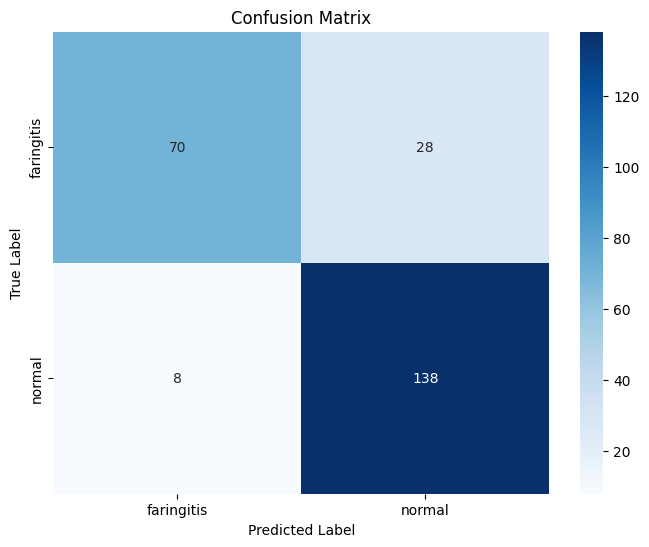

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



test_preds_probs = model.predict(test_generator, verbose=1)


test_preds = np.argmax(test_preds_probs, axis=1)


true_labels = test_generator.classes


class_labels = list(test_generator.class_indices.keys())


test_acc = accuracy_score(true_labels, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")


report = classification_report(true_labels, test_preds, target_names=class_labels, digits=4)
print("\nClassification Report:")
print(report)


cm = confusion_matrix(true_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


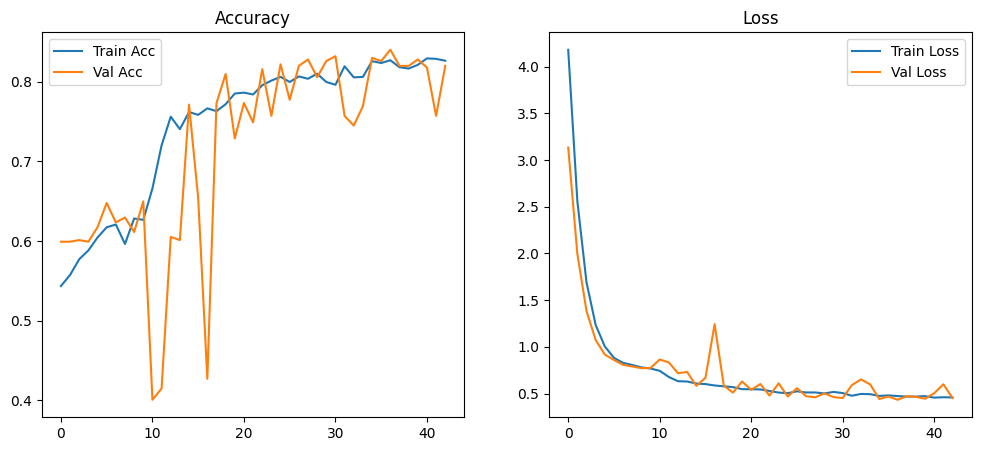

In [12]:
def plot_training(history, history_fine=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    if history_fine:
        acc += history_fine.history['accuracy']
        val_acc += history_fine.history['val_accuracy']
        loss += history_fine.history['loss']
        val_loss += history_fine.history['val_loss']

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_training(history, history_fine)
